## Readme
This Jupyter Notebook processes and analyzes behavioral data from mice experiments. The workflow includes loading data, preprocessing, analysis, and visualization. Below is a summary of the key steps and functions used in this notebook:

## Data Loading and Matching
- **dlc_files**: List of DLC (DeepLabCut) CSV files containing tracking data.
- **volume_files**: List of volume CSV files containing volume data.
- **dlc_folder_path**: Path to the folder containing DLC files.
- **volume_folder_path**: Path to the folder containing volume files.
- **match_files(dlc_files, volume_files)**: Matches DLC and volume files based on mouse ID and day.

## Data Preprocessing
- **load_and_trim_data(dlc_file_path, volume_file_path)**: Loads and trims DLC and volume data based on likelihood thresholding.
- **mark_sound_cues(volume_df)**: Marks sound cues in the volume data.
- **add_phase_column(dlc_df, volume_df)**: Adds a phase column to the DLC data based on sound cues.
- **remove_outliers(dlc_df)**: Removes outliers from the DLC data using interpolation.
- **calculate_corner_medians(dlc_df)**: Calculates the median coordinates of the corners.
- **apply_homography(dlc_df, corner_medians)**: Applies homography transformation to correct coordinates.
- **calculate_delta(dlc_df)**: Calculates distance, speed, and smoothed speed.
- **calculate_freezing(dlc_df)**: Calculates freezing behavior with a minimum duration of 2 seconds.

## Data Analysis
- **run_rmanova()**: Runs repeated measures ANOVA on the freezing results.
- **process_files(dlc_files, volume_files, dlc_folder_path, volume_folder_path)**: Main function to process all matched files and generate results.

## Visualization
- **plot_freezing_proportion(data, phase, save_fig)**: Plots freezing proportion for a given phase over days.
- **plot_freezing_proportion_by_phase(data, day, save_fig)**: Plots freezing proportion across phases for a given day.
- **plot_interaction(data, x_factor, trace_factor, response, figsize, dpi, save_fig)**: Creates an interaction plot for the given factors.

## Statistical Analysis
- **Two-way ANOVA**: Performed using statsmodels to analyze the effect of day and phase on freezing proportion.
- **Mixed Effects Model**: Built using statsmodels to account for random effects of mouse ID.
- **Repeated Measures ANOVA**: Performed using statsmodels to analyze within-subject effects.

## Results
- **results_df**: DataFrame containing the processed results, including freezing time, total time, and freezing proportion for each mouse, day, and phase.

This notebook provides a comprehensive analysis of the behavioral data, including preprocessing, statistical analysis, and visualization, to understand the effects of different phases and days on mice behavior.

In [99]:
# Data processing version 1.0
# Key features: 
# 1. Match DLC and volume files based on mouse ID and day
# 2. Load and trim data with likelihood thresholding
# 3. Mark sound cues in the volume data
# 4. Add phase column to the DLC data: neutral, pre, stim, post
# 5. Outlier removal using interpolation
# 6. Calculate corner medians and apply homography
# 7. Calculate delta (distance, speed, smoothing)
# 8. Calculate freezing with minimum duration of 2 seconds
# 9. Plot speed and freezing detection with time in seconds
# 10. RM ANOVA analysis for freezing_proportion with phase and day as within iv, and mouse_id as between iv


import os
import pandas as pd
import numpy as np
import cv2  # OpenCV library for homography
from scipy.ndimage import gaussian_filter1d  # For smoothing speed
from tqdm import tqdm  # For progress bar
import matplotlib.pyplot as plt  # For visualization

# Define paths for DLC and volume data folders
dlc_folder_path = '../data/dlc'
volume_folder_path = '../data/volume'

# List all DLC and volume CSV files
dlc_files = sorted([f for f in os.listdir(dlc_folder_path) if f.endswith('.csv')])
volume_files = sorted([f for f in os.listdir(volume_folder_path) if f.endswith('.csv')])

# Function to match DLC and volume files based on mouse ID and day
def match_files(dlc_files, volume_files):
    dlc_file_dict = {}
    for dlc_file in dlc_files:
        mouse_id, day = extract_mouse_id_and_day(dlc_file)
        if mouse_id and day:
            key = f"{mouse_id}_{day}"
            dlc_file_dict[key] = dlc_file

    volume_file_dict = {}
    for volume_file in volume_files:
        mouse_id, day = extract_mouse_id_and_day(volume_file)
        if mouse_id and day:
            key = f"{mouse_id}_{day}"
            volume_file_dict[key] = volume_file

    # Match DLC and volume files
    matched_files = []
    for key in dlc_file_dict:
        if key in volume_file_dict:
            matched_files.append((dlc_file_dict[key], volume_file_dict[key]))
        else:
            print(f"Warning: No matching volume file for DLC file {dlc_file_dict[key]}")

    return matched_files

# Function to extract mouse ID and day from file name
def extract_mouse_id_and_day(file_name):
    # Split the file name by underscores
    parts = file_name.split('_')
    if len(parts) < 2:
        return None, None

    # Extract day (e.g., 'day3')
    day_part = parts[0]
    if day_part.startswith('day'):
        day = day_part[3:]  # Extract the number after 'day'
    else:
        day = None

    # Extract mouse ID (e.g., '080')
    mouse_id = parts[1]

    return mouse_id, day

# Function to load and trim data with likelihood thresholding
def load_and_trim_data(dlc_file_path, volume_file_path, likelihood_threshold=0.8, min_consecutive=10, tolerance=25):
    # Load DLC data
    dlc_df = pd.read_csv(dlc_file_path, header=[0])
    dlc_df.columns = dlc_df.iloc[0] + dlc_df.iloc[1]  # Combine multi-level headers
    dlc_df = dlc_df.drop(dlc_df.index[0:2]).reset_index(drop=True)
    dlc_df.columns.values[0] = 'frame'
    dlc_df['frame'] = pd.to_numeric(dlc_df['frame'], errors='coerce')
    dlc_df = dlc_df.dropna(subset=['frame']).reset_index(drop=True)
    dlc_df['frame-correct'] = range(len(dlc_df))
    
    # Convert likelihood columns to numeric
    likelihood_cols = [col for col in dlc_df.columns if 'likelihood' in col]
    dlc_df[likelihood_cols] = dlc_df[likelihood_cols].apply(pd.to_numeric, errors='coerce')
    
    # Trim DLC data based on likelihood threshold
    above_threshold = dlc_df['bodycenterlikelihood'] >= likelihood_threshold
    start_index = next((i for i in range(len(above_threshold) - min_consecutive + 1)
                        if above_threshold.iloc[i:i + min_consecutive].all()), 0)
    dlc_df = dlc_df.iloc[start_index:].reset_index(drop=True)
    
    # Load volume data
    volume_df = pd.read_csv(volume_file_path, header=None, names=["volume"])
    volume_df = volume_df.iloc[start_index:].reset_index(drop=True)
    volume_df['frame'] = range(len(volume_df))
    
    # Sync lengths of DLC and volume data
    length_diff = abs(len(dlc_df) - len(volume_df))
    if length_diff > tolerance:
        print(f"Warning: Length difference exceeds {tolerance} frames: {length_diff} frames.")
    elif len(volume_df) > len(dlc_df):
        volume_df = volume_df.iloc[:len(dlc_df)].reset_index(drop=True)
    elif len(volume_df) < len(dlc_df):
        dlc_df = dlc_df.iloc[:len(volume_df)].reset_index(drop=True)
    
    return dlc_df, volume_df

# Function to mark sound cues in the volume data
def mark_sound_cues(volume_df, first_cue_threshold=-4, cue_duration=20 * 25, num_cues=10, inter_cue_interval=120 * 25):
    # Find first occurrence of 10 consecutive frames above threshold
    above_threshold = volume_df['volume'] > first_cue_threshold
    first_cue_start = None
    for i in range(len(above_threshold) - 9):
        if above_threshold.iloc[i:i + 10].all():
            first_cue_start = i
            break

    if first_cue_start is None:
        print("No valid sound cue detected.")
        volume_df['sound'] = 0
        return volume_df

    # Initialize sound column and mark sound cues
    volume_df['sound'] = 0
    for i in range(num_cues):
        cue_start = first_cue_start + i * inter_cue_interval
        cue_end = cue_start + cue_duration
        volume_df.loc[cue_start:cue_end, 'sound'] = 1

    return volume_df

# Function to add phase column to the DLC data
def add_phase_column(dlc_df, volume_df, cue_duration=20 * 25, pre_duration=20 * 25, post_duration=20 * 25):
    dlc_df['sound'] = volume_df['sound']  # Add sound column from volume_df
    dlc_df['phase'] = 'neutral'  # Initialize all as 'neutral'

    # Identify the indices where sound cues start
    cue_starts = volume_df[(volume_df['sound'] == 1) & (volume_df['sound'].shift(1) == 0)].index

    # Loop through each cue to mark phases
    for cue_start in cue_starts:
        pre_start = max(cue_start - pre_duration, 0)
        stim_end = cue_start + cue_duration
        post_end = stim_end + post_duration

        dlc_df.loc[pre_start:cue_start - 1, 'phase'] = 'pre'
        dlc_df.loc[cue_start:stim_end - 1, 'phase'] = 'stim'
        dlc_df.loc[stim_end:post_end - 1, 'phase'] = 'post'

    return dlc_df

# Modified function for outlier removal using interpolation
def remove_outliers(dlc_df, likelihood_threshold=0.3, max_interpolation_gap=25):
    # Identify low-likelihood frames
    low_likelihood = dlc_df['bodycenterlikelihood'] < likelihood_threshold

    # Replace low-likelihood positions with NaN
    dlc_df.loc[low_likelihood, ['bodycenterx', 'bodycentery']] = np.nan

    # Interpolate to fill NaN values, limiting the maximum interpolation gap
    for col in ['bodycenterx', 'bodycentery']:
        dlc_df[col] = dlc_df[col].interpolate(method='linear', limit=max_interpolation_gap, limit_direction='both')

    # Handle remaining NaNs by forward/backward filling
    dlc_df[['bodycenterx', 'bodycentery']] = dlc_df[['bodycenterx', 'bodycentery']].fillna(method='bfill').fillna(method='ffill')

    return dlc_df

# Function to calculate corner medians
def calculate_corner_medians(dlc_df):
    corner_columns = ['topleftcornerx', 'topleftcornery', 'toprightcornerx', 'toprightcornery',
                      'bottomleftcornerx', 'bottomleftcornery', 'bottomrightcornerx', 'bottomrightcornery']
    dlc_df[corner_columns] = dlc_df[corner_columns].apply(pd.to_numeric, errors='coerce')
    corner_medians = dlc_df[corner_columns].median()
    return corner_medians

# Function to apply homography
def apply_homography(dlc_df, corner_medians):
    # Define source and destination points for homography
    src_points = np.array([
        [corner_medians['topleftcornerx'], corner_medians['topleftcornery']],
        [corner_medians['toprightcornerx'], corner_medians['toprightcornery']],
        [corner_medians['bottomleftcornerx'], corner_medians['bottomleftcornery']],
        [corner_medians['bottomrightcornerx'], corner_medians['bottomrightcornery']]
    ])

    # Destination points (20cm x 20cm arena)
    dst_points = np.array([
        [0, 0],
        [20, 0],
        [0, 20],
        [20, 20]
    ])

    # Compute homography matrix
    homography_matrix, _ = cv2.findHomography(src_points, dst_points)

    # Apply homography to bodycenter coordinates
    points = dlc_df[['bodycenterx', 'bodycentery']].values.reshape(-1, 1, 2).astype(np.float32)
    transformed_points = cv2.perspectiveTransform(points, homography_matrix)
    dlc_df[['corrected_x', 'corrected_y']] = transformed_points.reshape(-1, 2)

    return dlc_df

# Function to calculate delta (distance, speed, smoothing)
def calculate_delta(dlc_df, fps=25):
    # Calculate frame-to-frame differences
    dlc_df['delta_x'] = dlc_df['corrected_x'].diff()
    dlc_df['delta_y'] = dlc_df['corrected_y'].diff()
    dlc_df['distance'] = np.sqrt(dlc_df['delta_x']**2 + dlc_df['delta_y']**2)

    # Calculate speed (cm/s)
    dlc_df['speed'] = dlc_df['distance'] * fps

    # Apply smoothing to speed
    dlc_df['smoothed_speed'] = gaussian_filter1d(dlc_df['speed'].fillna(0), sigma=2)

    return dlc_df

# Modified function to calculate freezing with minimum duration of 2 seconds
def calculate_freezing(dlc_df, speed_threshold=1, min_freeze_duration_frames=50, fps=25):
    # Identify frames where speed is below the threshold
    dlc_df['is_below_threshold'] = dlc_df['smoothed_speed'] < speed_threshold

    # Identify continuous periods of freezing
    dlc_df['freezing_group'] = (dlc_df['is_below_threshold'] != dlc_df['is_below_threshold'].shift()).cumsum()
    freezing_periods = dlc_df[dlc_df['is_below_threshold']].groupby('freezing_group').filter(lambda x: len(x) >= min_freeze_duration_frames)

    # Mark frames that are part of a valid freezing period
    dlc_df['is_freezing'] = 0
    dlc_df.loc[freezing_periods.index, 'is_freezing'] = 1

    # Calculate total freezing time and proportion for each phase
    freezing_summary = dlc_df.groupby('phase')['is_freezing'].agg(['sum', 'count'])
    freezing_summary['freezing_time_sec'] = freezing_summary['sum'] / fps
    freezing_summary['total_time_sec'] = freezing_summary['count'] / fps
    freezing_summary['freezing_proportion'] = freezing_summary['sum'] / freezing_summary['count']

    # Clean up temporary columns
    dlc_df.drop(['is_below_threshold', 'freezing_group'], axis=1, inplace=True)
    
    return freezing_summary[['freezing_time_sec', 'total_time_sec', 'freezing_proportion']].reset_index()

# Function to plot speed and freezing detection with time in seconds
def plot_freezing(dlc_df, mouse_id, day, fps=25):
    time_sec = dlc_df.index / fps  # Convert frame indices to time in seconds
    plt.figure(figsize=(15, 5))
    plt.plot(time_sec, dlc_df['smoothed_speed'], label='Smoothed Speed (cm/s)')
    plt.plot(time_sec, dlc_df['is_freezing'] * dlc_df['smoothed_speed'].max(), label='Freezing Periods', alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (cm/s)')
    plt.title(f'Mouse {mouse_id} Day {day} - Speed and Freezing Detection')
    plt.legend()
    plt.tight_layout()
    # Save the plot as an image file
    output_dir = 'plots'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'Mouse_{mouse_id}_Day_{day}_Freezing.png'))
    plt.close()

# Function for RM ANOVA analysis, where freezing_proportion is dv, within iv is phase and days, and between iv is mouse_id
# p-unc is the p-value based on the uncorrected degrees of freedom, 
# p-GG-corr is the p-value based on the Greenhouse-Geisser correction, 
# ng2 is the generalized eta-squared effect size, 
# eps is the epsilon value for the Greenhouse-Geisser correction.
def run_rmanova(): 
    import pingouin as pg
    # Load the data
    data = pd.read_csv('freezing_results.csv')
    # Run the repeated measures ANOVA
    rm_anova = pg.rm_anova(data=data, dv='freezing_proportion', within=['phase', 'day'], subject='mouse_id')
    # Print the results
    print(rm_anova)


# Main processing function
def process_files(dlc_files, volume_files, dlc_folder_path, volume_folder_path):
    # Match DLC and volume files based on mouse ID and day
    matched_files = match_files(dlc_files, volume_files)

    all_results = []
    for dlc_file, volume_file in tqdm(matched_files, total=len(matched_files), desc="Processing files"):
        dlc_file_path = os.path.join(dlc_folder_path, dlc_file)
        volume_file_path = os.path.join(volume_folder_path, volume_file)

        # Extract mouse ID and day from file name
        mouse_id, day = extract_mouse_id_and_day(dlc_file)

        # Load and trim data
        dlc_data, volume_data = load_and_trim_data(dlc_file_path, volume_file_path)

        # Mark sound cues
        marked_volume_data = mark_sound_cues(volume_data)

        # Add phase column to DLC data
        dlc_data = add_phase_column(dlc_data, marked_volume_data)

        # Outlier removal with interpolation
        dlc_data = remove_outliers(dlc_data)

        # Calculate corner medians
        corner_medians = calculate_corner_medians(dlc_data)

        # Apply homography
        dlc_data = apply_homography(dlc_data, corner_medians)

        # Calculate delta (distance, speed, smoothing)
        dlc_data = calculate_delta(dlc_data)

        # Calculate freezing with minimum duration of 2 seconds
        freezing_summary = calculate_freezing(dlc_data)

        # Add mouse ID and day to freezing summary
        freezing_summary['mouse_id'] = mouse_id
        freezing_summary['day'] = day

        # Append results
        all_results.append(freezing_summary)

        # Optionally, save the processed DLC data with all added columns
        output_dir = 'processed_data'
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f'{mouse_id}_Day{day}_processed.csv')
        dlc_data.to_csv(output_file, index=False)

        # Plot speed and freezing detection with time in seconds
        plot_freezing(dlc_data, mouse_id, day)

    # Combine all results into a single DataFrame
    results_df = pd.concat(all_results, ignore_index=True)
    return results_df

# Run the processing
if __name__ == '__main__':
    results_df = process_files(dlc_files, volume_files, dlc_folder_path, volume_folder_path)

    # Save the results to a CSV file
    results_df.to_csv('freezing_results.csv', index=False)
    run_rmanova()  # Run RM ANOVA analysis  

    # Display the results
    print("Freezing Results:")
    print(results_df)

Processing files:   0%|          | 0/40 [00:00<?, ?it/s]/var/folders/wp/rkw0mtqs4856nczw_4ydgjcc0000gn/T/ipykernel_37868/20527503.py:79: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_df = pd.read_csv(dlc_file_path, header=[0])
Processing files:   2%|▎         | 1/40 [00:04<02:53,  4.46s/it]/var/folders/wp/rkw0mtqs4856nczw_4ydgjcc0000gn/T/ipykernel_37868/20527503.py:79: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_df = pd.read_csv(dlc_file_path, header=[0])
Processing files:   5%|▌         | 2/40 [00:08<02:33,  4.04s/it]/var/folders/wp/rkw0mtqs4856nczw_4ydgjcc0000gn/T/ipykernel_37868/20527503.py:79: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26

        Source        SS  ddof1  ddof2        MS          F         p-unc  \
0        phase  0.099906      3     21  0.033302   5.145588  7.989619e-03   
1          day  2.358909      4     28  0.589727  18.852565  1.276142e-07   
2  phase * day  0.107876     12     84  0.008990   2.499051  7.447145e-03   

   p-GG-corr       ng2       eps  
0   0.048034  0.056664  0.393035  
1   0.000082  0.586480  0.519497  
2   0.118065  0.060909  0.166541  
Freezing Results:
       phase  freezing_time_sec  total_time_sec  freezing_proportion mouse_id  \
0    neutral               5.60         1325.72             0.004224      062   
1       post               0.00          200.00             0.000000      062   
2        pre               0.00          200.00             0.000000      062   
3       stim               0.00          200.00             0.000000      062   
4    neutral              17.12         1326.00             0.012911      063   
..       ...                ...             ...


/Users/apple/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


In [100]:
# Plotting the freezing proportion for each phase over days. x-axis is days, y-axis is freezing proportion.
# Four plots will be generated for each phase: pre, stim, post, and neutral.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the freezing results data from the CSV file
results_df = pd.read_csv('freezing_results.csv')

def plot_freezing_proportion(data, phase, save_fig=False):
    """
    Plots the freezing proportion for a given phase over days with optimized visualization.

    Parameters:
    - data: DataFrame containing the freezing results.
    - phase: String, the phase to plot ('pre', 'stim', 'post', 'neutral').
    - save_fig: Boolean, if True, saves the figure as a PNG file.

    """
    # Filter data to include only the specified phase
    phase_data = data[data['phase'] == phase].copy()
    
    # Convert 'day' column to integers for proper sorting
    phase_data['day'] = phase_data['day'].astype(int)
    
    # Extract the freezing proportion for each mouse on each day
    mouse_day_data = phase_data[['mouse_id', 'day', 'freezing_proportion']]
    
    # Set up the plot with increased dpi for higher resolution
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Use a specific style for better aesthetics
    sns.set_style("whitegrid")
    
    # Increase font sizes and set fonts to bold
    sns.set_context("talk", font_scale=1.2)
    
    # Create a color palette
    palette = sns.color_palette("Pastel1")
    
    # Create a box plot of freezing proportion for each day
    sns.boxplot(x='day', y='freezing_proportion', data=mouse_day_data, color=palette[0],
                width=0.6, linewidth=2.5, fliersize=0)
    
    # Overlay scatter plot of individual mouse data
    sns.stripplot(x='day', y='freezing_proportion', data=mouse_day_data, color='black',
                  size=8, jitter=True)
    
    # Customize the plot
    plt.xlabel('Day', fontsize=16, fontweight='bold')
    plt.ylabel('Freezing Proportion (%)', fontsize=16, fontweight='bold')
    plt.title(f'Freezing Proportion During {phase.capitalize()} Phase Over Days',
              fontsize=18, fontweight='bold')
    plt.ylim(0, 1)  # Freezing proportion ranges from 0 to 1
    
    # Adjust x-axis tick labels font size and weight without setting positions
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    
    # Convert y-axis labels to percentage format
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    
    # Remove top and right spines for a cleaner look
    sns.despine(trim=True)
    
    plt.tight_layout()
    
    if save_fig:
        # Save the figure with a high dpi
        plt.savefig(f'freezing_proportion_{phase}.png', dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# List of phases to plot
phases = ['pre', 'stim', 'post', 'neutral']

# Loop over phases and plot each
for phase in phases:
    plot_freezing_proportion(results_df, phase, save_fig=True)

In [101]:
# Plotting the freezing proportion for each phase over days. x-axis is phase, y-axis is freezing proportion.
# Five plots are genrated for each day.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the freezing results data from the CSV file
results_df = pd.read_csv('freezing_results.csv')

def plot_freezing_proportion_by_phase(data, day, save_fig=False):
    """
    Plots the freezing proportion across phases for a given day with optimized visualization.

    Parameters:
    - data: DataFrame containing the freezing results.
    - day: Integer, the day to plot.
    - save_fig: Boolean, if True, saves the figure as a PNG file.

    """
    # Filter data to include only the specified day
    day_data = data[data['day'].astype(int) == day].copy()
    
    # Ensure 'phase' is ordered correctly
    phase_order = ['neutral', 'pre', 'stim', 'post']
    day_data['phase'] = pd.Categorical(day_data['phase'], categories=phase_order, ordered=True)
    
    # Extract the freezing proportion for each mouse in each phase
    mouse_phase_data = day_data[['mouse_id', 'phase', 'freezing_proportion']]
    
    # Set up the plot with increased dpi for higher resolution
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Use a specific style for better aesthetics
    sns.set_style("whitegrid")
    
    # Increase font sizes and set fonts to bold
    sns.set_context("talk", font_scale=1.2)
    
    # Create a color palette
    palette = sns.color_palette("Pastel1")
    
    # Create a box plot of freezing proportion for each phase
    sns.boxplot(x='phase', y='freezing_proportion', data=mouse_phase_data, color=palette[1],
                width=0.6, linewidth=2.5, fliersize=0)
    
    # Overlay scatter plot of individual mouse data
    sns.stripplot(x='phase', y='freezing_proportion', data=mouse_phase_data, color='black',
                  size=8, jitter=True)
    
    # Customize the plot
    plt.xlabel('Phase', fontsize=16, fontweight='bold')
    plt.ylabel('Freezing Proportion (%)', fontsize=16, fontweight='bold')
    plt.title(f'Freezing Proportion Across Phases on Day {day}',
              fontsize=18, fontweight='bold')
    plt.ylim(0, 1)  # Freezing proportion ranges from 0 to 1
    
    # Adjust x-axis tick labels font size and weight
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    
    # Convert y-axis labels to percentage format
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    
    # Remove top and right spines for a cleaner look
    sns.despine(trim=True)
    
    plt.tight_layout()
    
    if save_fig:
        # Save the figure with a high dpi
        plt.savefig(f'freezing_proportion_day_{day}.png', dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# List of days to plot
days = sorted(results_df['day'].astype(int).unique())

# Loop over days and plot each
for day in days:
    plot_freezing_proportion_by_phase(results_df, day, save_fig=True)

Two-way ANOVA Results:
                   sum_sq     df          F        PR(>F)
C(day)           2.358909    4.0  49.639206  6.005592e-26
C(phase)         0.099906    3.0   2.803140  4.213999e-02
C(day):C(phase)  0.107876   12.0   0.756689  6.936812e-01
Residual         1.663238  140.0        NaN           NaN


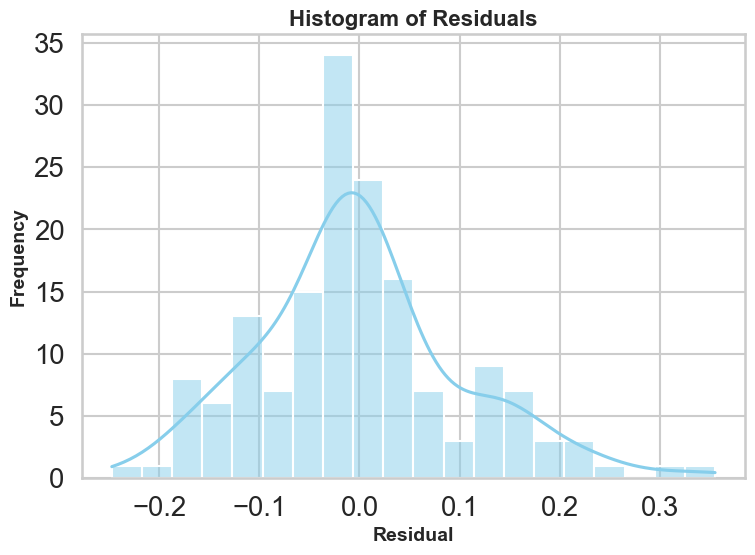


Shapiro-Wilk Test for Normality of Residuals:
Statistic = 0.9721, p-value = 0.0025


In [102]:
# Perform two-way ANOVA and check assumptions

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the freezing results data from the CSV file
results_df = pd.read_csv('freezing_results.csv')

# Convert 'day' to integer
results_df['day'] = results_df['day'].astype(int)

# Ensure 'phase' is treated as a categorical variable with a specific order
phase_order = ['neutral', 'pre', 'stim', 'post']
results_df['phase'] = pd.Categorical(results_df['phase'], categories=phase_order, ordered=True)

# Prepare the data for ANOVA
# The dependent variable is 'freezing_proportion'
# The independent variables are 'day' and 'phase'

# Perform two-way ANOVA using statsmodels
# Build the formula: 'freezing_proportion ~ C(day) * C(phase)'
model = ols('freezing_proportion ~ C(day) * C(phase)', data=results_df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Use Type II sums of squares

# Print the ANOVA table
print("Two-way ANOVA Results:")
print(anova_table)

# Check assumptions of ANOVA

# 1. Residuals should be normally distributed
# Get the residuals
residuals = model.resid

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=20, color='skyblue')
plt.title('Histogram of Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Residual', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Perform Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print("\nShapiro-Wilk Test for Normality of Residuals:")
print(f"Statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# # 2. Homogeneity of variances
# # Perform Levene's test
# from scipy.stats import levene

# # Levene's test requires the data grouped by combinations of factors
# grouped = results_df.groupby(['day', 'phase'])['freezing_proportion']

# # Create a list of arrays for each group
# group_values = [group for name, group in grouped]

# # Perform Levene's test
# levene_stat, levene_p = levene(*group_values, center='median')
# print("\nLevene's Test for Homogeneity of Variance:")
# print(f"Statistic = {levene_stat:.4f}, p-value = {levene_p:.4f}")

In [103]:
# mixed effects model

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Read the freezing results data from the CSV file
results_df = pd.read_csv('freezing_results.csv')

# Convert 'day' to integer
results_df['day'] = results_df['day'].astype(int)

# Ensure 'phase' is treated as a categorical variable with a specific order
phase_order = ['neutral', 'pre', 'stim', 'post']
results_df['phase'] = pd.Categorical(results_df['phase'], categories=phase_order, ordered=True)

# Prepare the data for the mixed effects model
# The dependent variable is 'freezing_proportion'
# The fixed effects are 'day' and 'phase'
# The random effect is 'mouse_id'

# Build the mixed effects model
# The formula syntax is: 'dependent variable ~ fixed effects'
# Random effects are specified separately

# Define the model
model = mixedlm("freezing_proportion ~ C(day) * C(phase)", data=results_df, groups=results_df["mouse_id"])

# Fit the model
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

                 Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   freezing_proportion
No. Observations:   160       Method:               REML               
No. Groups:         8         Scale:                0.0099             
Min. group size:    20        Log-Likelihood:       98.0977            
Max. group size:    20        Converged:            Yes                
Mean group size:    20.0                                               
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.019    0.039  0.503 0.615 -0.056  0.095
C(day)[T.2]                   0.145    0.050  2.913 0.004  0.047  0.242
C(day)[T.3]                   0.173    0.050  3.485 0.000  0.076  0.271
C(day)[T.4]                   0.127    0.050  2.550 0.011  0.029  0.224
C(day)[T.

/Users/apple/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [104]:
# Plot the interaction between 'day' and 'phase', and RM ANOVA.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from statsmodels.graphics.factorplots import interaction_plot

# Read the freezing results data from the CSV file
results_df = pd.read_csv('freezing_results.csv')

# Convert 'day' to integer
results_df['day'] = results_df['day'].astype(int)

# Ensure 'phase' is treated as a categorical variable with a specific order
phase_order = ['neutral', 'pre', 'stim', 'post']
results_df['phase'] = pd.Categorical(results_df['phase'], categories=phase_order, ordered=True)

# Perform Repeated Measures ANOVA
rm_anova = AnovaRM(data=results_df, depvar='freezing_proportion', subject='mouse_id', within=['day', 'phase'])
rm_anova_results = rm_anova.fit()

# Print the ANOVA table
print("Repeated Measures ANOVA Results:")
print(rm_anova_results)

# Optimize the interaction plot for better visualization
def plot_interaction(data, x_factor, trace_factor, response, figsize=(6, 4), dpi=150, save_fig=False):
    """
    Creates an optimized interaction plot with enhanced visualization.

    Parameters:
    - data: DataFrame containing the data.
    - x_factor: String, the factor to plot on the x-axis.
    - trace_factor: String, the factor to represent with different lines.
    - response: String, the dependent variable.
    - figsize: Tuple, the size of the figure.
    - dpi: Integer, the resolution of the figure.
    - save_fig: Boolean, if True, saves the figure as a PNG file.
    """
    # Use a specific style for better aesthetics
    sns.set_style("whitegrid")

    # Increase font sizes and set fonts to bold
    sns.set_context("talk", font_scale=1.2)

    # Create a color palette
    num_traces = len(data[trace_factor].unique())
    palette = sns.color_palette("Set2", n_colors=num_traces)

    # Ensure markers and linestyles have the correct length
    markers = ['o', 's', '^', 'D']
    linestyles = ['-'] * num_traces

    # Adjust markers and linestyles if necessary
    if num_traces > len(markers):
        markers = markers * (num_traces // len(markers) + 1)
    if num_traces > len(linestyles):
        linestyles = linestyles * (num_traces // len(linestyles) + 1)

    # Create the interaction plot
    fig = interaction_plot(
        x=data[x_factor],
        trace=data[trace_factor],
        response=data[response],
        colors=palette,
        markers=markers[:num_traces],
        linestyles=linestyles[:num_traces],
        ms=8,
        linewidth=2
    )

    # Get the Axes object from the Figure
    ax = fig.axes[0]

    # Customize the plot
    ax.set_xlabel(x_factor.capitalize(), fontsize=16, fontweight='bold')
    ax.set_ylabel('Mean Freezing Proportion (%)', fontsize=16, fontweight='bold')
    ax.set_title(f'Interaction Plot: {x_factor.capitalize()} vs. {trace_factor.capitalize()}', fontsize=18, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Convert y-axis labels to percentage format
    from matplotlib.ticker import PercentFormatter
    ax.yaxis.set_major_formatter(PercentFormatter(1))

    # Adjust the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title=trace_factor.capitalize(), fontsize=12, title_fontsize=14)

    # Remove top and right spines for a cleaner look
    sns.despine(ax=ax, trim=True)

    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)

    plt.tight_layout()

    if save_fig:
        # Save the figure with a high dpi
        plt.savefig(f'interaction_plot_{x_factor}_vs_{trace_factor}.png', dpi=dpi, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# Call the function to plot the interaction between 'day' and 'phase'
plot_interaction(
    data=results_df,
    x_factor='day',
    trace_factor='phase',
    response='freezing_proportion',
    figsize=(6, 4),
    dpi=150,
    save_fig=True  # Set to True if you want to save the figure
)

Repeated Measures ANOVA Results:
                 Anova
          F Value  Num DF  Den DF Pr > F
----------------------------------------
day       18.8526  4.0000 28.0000 0.0000
phase      5.1456  3.0000 21.0000 0.0080
day:phase  2.4991 12.0000 84.0000 0.0074



# Version 2.0
## Phase changes to pre, stim, post 
- pre: first 10 mins before the first sound cue.
- stim: 20s of each sound cue * 10 cues
- post: last 20 mins after the start of the first sound cue.

## Separated by group: OFC and BLA


In [112]:
# Data processing version 2.0
# Key changes:
# 1. add_phase_column(): phases changed to 'pre', 'stim', 'post'.
# 2. added group column to the freezing summary. BLA and OFC groups.

import os
import pandas as pd
import numpy as np
import cv2  # OpenCV library for homography
from scipy.ndimage import gaussian_filter1d  # For smoothing speed
from tqdm import tqdm  # For progress bar
import matplotlib.pyplot as plt  # For visualization

# Define paths for DLC and volume data folders
dlc_folder_path = '../data/dlc'
volume_folder_path = '../data/volume'

# List all DLC and volume CSV files
dlc_files = sorted([f for f in os.listdir(dlc_folder_path) if f.endswith('.csv')])
volume_files = sorted([f for f in os.listdir(volume_folder_path) if f.endswith('.csv')])

# Function to match DLC and volume files based on mouse ID and day
def match_files(dlc_files, volume_files):
    dlc_file_dict = {}
    for dlc_file in dlc_files:
        mouse_id, day = extract_mouse_id_and_day(dlc_file)
        if mouse_id and day:
            key = f"{mouse_id}_{day}"
            dlc_file_dict[key] = dlc_file

    volume_file_dict = {}
    for volume_file in volume_files:
        mouse_id, day = extract_mouse_id_and_day(volume_file)
        if mouse_id and day:
            key = f"{mouse_id}_{day}"
            volume_file_dict[key] = volume_file

    # Match DLC and volume files
    matched_files = []
    for key in dlc_file_dict:
        if key in volume_file_dict:
            matched_files.append((dlc_file_dict[key], volume_file_dict[key]))
        else:
            print(f"Warning: No matching volume file for DLC file {dlc_file_dict[key]}")

    return matched_files

# Function to extract mouse ID and day from file name
def extract_mouse_id_and_day(file_name):
    # Split the file name by underscores
    parts = file_name.split('_')
    if len(parts) < 2:
        return None, None

    # Extract day (e.g., 'day3')
    day_part = parts[0]
    if day_part.startswith('day'):
        day = day_part[3:]  # Extract the number after 'day'
    else:
        day = None

    # Extract mouse ID (e.g., '080')
    mouse_id = parts[1]

    return mouse_id, day

# Function to load and trim data with likelihood thresholding
def load_and_trim_data(dlc_file_path, volume_file_path, likelihood_threshold=0.8, min_consecutive=10, tolerance=25):
    # Load DLC data
    dlc_df = pd.read_csv(dlc_file_path, header=[0])
    dlc_df.columns = dlc_df.iloc[0] + dlc_df.iloc[1]  # Combine multi-level headers
    dlc_df = dlc_df.drop(dlc_df.index[0:2]).reset_index(drop=True)
    dlc_df.columns.values[0] = 'frame'
    dlc_df['frame'] = pd.to_numeric(dlc_df['frame'], errors='coerce')
    dlc_df = dlc_df.dropna(subset=['frame']).reset_index(drop=True)
    dlc_df['frame-correct'] = range(len(dlc_df))
    
    # Convert likelihood columns to numeric
    likelihood_cols = [col for col in dlc_df.columns if 'likelihood' in col]
    dlc_df[likelihood_cols] = dlc_df[likelihood_cols].apply(pd.to_numeric, errors='coerce')
    
    # Trim DLC data based on likelihood threshold
    above_threshold = dlc_df['bodycenterlikelihood'] >= likelihood_threshold
    start_index = next((i for i in range(len(above_threshold) - min_consecutive + 1)
                        if above_threshold.iloc[i:i + min_consecutive].all()), 0)
    dlc_df = dlc_df.iloc[start_index:].reset_index(drop=True)
    
    # Load volume data
    volume_df = pd.read_csv(volume_file_path, header=None, names=["volume"])
    volume_df = volume_df.iloc[start_index:].reset_index(drop=True)
    volume_df['frame'] = range(len(volume_df))
    
    # Sync lengths of DLC and volume data
    length_diff = abs(len(dlc_df) - len(volume_df))
    if length_diff > tolerance:
        print(f"Warning: Length difference exceeds {tolerance} frames: {length_diff} frames.")
    elif len(volume_df) > len(dlc_df):
        volume_df = volume_df.iloc[:len(dlc_df)].reset_index(drop=True)
    elif len(volume_df) < len(dlc_df):
        dlc_df = dlc_df.iloc[:len(volume_df)].reset_index(drop=True)
    
    return dlc_df, volume_df

# Function to mark sound cues in the volume data
def mark_sound_cues(volume_df, first_cue_threshold=-4, cue_duration=20 * 25, num_cues=10, inter_cue_interval=120 * 25):
    # Find first occurrence of 10 consecutive frames above threshold
    above_threshold = volume_df['volume'] > first_cue_threshold
    first_cue_start = None
    for i in range(len(above_threshold) - 9):
        if above_threshold.iloc[i:i + 10].all():
            first_cue_start = i
            break

    if first_cue_start is None:
        print("No valid sound cue detected.")
        volume_df['sound'] = 0
        return volume_df

    # Initialize sound column and mark sound cues
    volume_df['sound'] = 0
    for i in range(num_cues):
        cue_start = first_cue_start + i * inter_cue_interval
        cue_end = cue_start + cue_duration
        volume_df.loc[cue_start:cue_end, 'sound'] = 1

    return volume_df

# Function to add phase column to the DLC data
def add_phase_column(dlc_df, volume_df):
    dlc_df['sound'] = volume_df['sound']  # Add sound column from volume_df
    dlc_df['phase'] = 'neutral'  # Initialize all as 'neutral'

    # Identify the index where the first sound cue starts
    first_cue_start = volume_df[volume_df['sound'] == 1].index[0]

    # Mark phases
    dlc_df.loc[:first_cue_start - 1, 'phase'] = 'pre'
    dlc_df.loc[first_cue_start:, 'phase'] = 'post'
    dlc_df.loc[volume_df['sound'] == 1, 'phase'] = 'stim'

    return dlc_df

# Function to add phase column to the DLC data
# def add_phase_column(dlc_df, volume_df):
#     dlc_df['sound'] = volume_df['sound']  # Add sound column from volume_df
#     dlc_df['phase'] = 'neutral'  # Initialize all as 'neutral'

#     # Identify the first sound cue start and last sound cue end
#     sound_indices = volume_df[volume_df['sound'] == 1].index
#     if len(sound_indices) > 0:
#         first_cue_start = sound_indices[0]
#         last_cue_end = sound_indices[-1]

#         # Mark phases
#         dlc_df.loc[:first_cue_start - 1, 'phase'] = 'pre'
#         dlc_df.loc[first_cue_start:last_cue_end, 'phase'] = 'stim'
#         dlc_df.loc[last_cue_end + 1:, 'phase'] = 'post'

#     return dlc_df

# Modified function for outlier removal using interpolation
def remove_outliers(dlc_df, likelihood_threshold=0.3, max_interpolation_gap=25):
    # Identify low-likelihood frames
    low_likelihood = dlc_df['bodycenterlikelihood'] < likelihood_threshold

    # Replace low-likelihood positions with NaN
    dlc_df.loc[low_likelihood, ['bodycenterx', 'bodycentery']] = np.nan

    # Interpolate to fill NaN values, limiting the maximum interpolation gap
    for col in ['bodycenterx', 'bodycentery']:
        dlc_df[col] = dlc_df[col].interpolate(method='linear', limit=max_interpolation_gap, limit_direction='both')

    # Handle remaining NaNs by forward/backward filling
    dlc_df[['bodycenterx', 'bodycentery']] = dlc_df[['bodycenterx', 'bodycentery']].fillna(method='bfill').fillna(method='ffill')

    return dlc_df

# Function to calculate corner medians
def calculate_corner_medians(dlc_df):
    corner_columns = ['topleftcornerx', 'topleftcornery', 'toprightcornerx', 'toprightcornery',
                      'bottomleftcornerx', 'bottomleftcornery', 'bottomrightcornerx', 'bottomrightcornery']
    dlc_df[corner_columns] = dlc_df[corner_columns].apply(pd.to_numeric, errors='coerce')
    corner_medians = dlc_df[corner_columns].median()
    return corner_medians

# Function to apply homography
def apply_homography(dlc_df, corner_medians):
    # Define source and destination points for homography
    src_points = np.array([
        [corner_medians['topleftcornerx'], corner_medians['topleftcornery']],
        [corner_medians['toprightcornerx'], corner_medians['toprightcornery']],
        [corner_medians['bottomleftcornerx'], corner_medians['bottomleftcornery']],
        [corner_medians['bottomrightcornerx'], corner_medians['bottomrightcornery']]
    ])

    # Destination points (20cm x 20cm arena)
    dst_points = np.array([
        [0, 0],
        [20, 0],
        [0, 20],
        [20, 20]
    ])

    # Compute homography matrix
    homography_matrix, _ = cv2.findHomography(src_points, dst_points)

    # Apply homography to bodycenter coordinates
    points = dlc_df[['bodycenterx', 'bodycentery']].values.reshape(-1, 1, 2).astype(np.float32)
    transformed_points = cv2.perspectiveTransform(points, homography_matrix)
    dlc_df[['corrected_x', 'corrected_y']] = transformed_points.reshape(-1, 2)

    return dlc_df

# Function to calculate delta (distance, speed, smoothing)
def calculate_delta(dlc_df, fps=25):
    # Calculate frame-to-frame differences
    dlc_df['delta_x'] = dlc_df['corrected_x'].diff()
    dlc_df['delta_y'] = dlc_df['corrected_y'].diff()
    dlc_df['distance'] = np.sqrt(dlc_df['delta_x']**2 + dlc_df['delta_y']**2)

    # Calculate speed (cm/s)
    dlc_df['speed'] = dlc_df['distance'] * fps

    # Apply smoothing to speed
    dlc_df['smoothed_speed'] = gaussian_filter1d(dlc_df['speed'].fillna(0), sigma=2)

    return dlc_df

# Modified function to calculate freezing with minimum duration of 2 seconds
def calculate_freezing(dlc_df, speed_threshold=1, min_freeze_duration_frames=50, fps=25):
    # Identify frames where speed is below the threshold
    dlc_df['is_below_threshold'] = dlc_df['smoothed_speed'] < speed_threshold

    # Identify continuous periods of freezing
    dlc_df['freezing_group'] = (dlc_df['is_below_threshold'] != dlc_df['is_below_threshold'].shift()).cumsum()
    freezing_periods = dlc_df[dlc_df['is_below_threshold']].groupby('freezing_group').filter(lambda x: len(x) >= min_freeze_duration_frames)

    # Mark frames that are part of a valid freezing period
    dlc_df['is_freezing'] = 0
    dlc_df.loc[freezing_periods.index, 'is_freezing'] = 1

    # Calculate total freezing time and proportion for each phase
    freezing_summary = dlc_df.groupby('phase')['is_freezing'].agg(['sum', 'count'])
    freezing_summary['freezing_time_sec'] = freezing_summary['sum'] / fps
    freezing_summary['total_time_sec'] = freezing_summary['count'] / fps
    freezing_summary['freezing_proportion'] = freezing_summary['sum'] / freezing_summary['count']

    # Clean up temporary columns
    dlc_df.drop(['is_below_threshold', 'freezing_group'], axis=1, inplace=True)
    
    return freezing_summary[['freezing_time_sec', 'total_time_sec', 'freezing_proportion']].reset_index()

# Function to plot speed and freezing detection with time in seconds
def plot_freezing(dlc_df, mouse_id, day, fps=25):
    time_sec = dlc_df.index / fps  # Convert frame indices to time in seconds
    plt.figure(figsize=(15, 5))
    plt.plot(time_sec, dlc_df['smoothed_speed'], label='Smoothed Speed (cm/s)')
    plt.plot(time_sec, dlc_df['is_freezing'] * dlc_df['smoothed_speed'].max(), label='Freezing Periods', alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (cm/s)')
    plt.title(f'Mouse {mouse_id} Day {day} - Speed and Freezing Detection')
    plt.legend()
    plt.tight_layout()
    # Save the plot as an image file
    output_dir = 'plots'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'Mouse_{mouse_id}_Day_{day}_Freezing.png'))
    plt.close()

# Function for RM ANOVA analysis, where freezing_proportion is dv, within iv is phase and days, and between iv is mouse_id
# p-unc is the p-value based on the uncorrected degrees of freedom, 
# p-GG-corr is the p-value based on the Greenhouse-Geisser correction, 
# ng2 is the generalized eta-squared effect size, 
# eps is the epsilon value for the Greenhouse-Geisser correction.
def run_rmanova(): 
    import pingouin as pg
    # Load the data
    data = pd.read_csv('freezing_results.csv')
    # Run the repeated measures ANOVA
    rm_anova = pg.rm_anova(data=data, dv='freezing_proportion', within=['phase', 'day'], subject='mouse_id')
    # Print the results
    print(rm_anova)


# Main processing function
def process_files(dlc_files, volume_files, dlc_folder_path, volume_folder_path):
    # Match DLC and volume files based on mouse ID and day
    matched_files = match_files(dlc_files, volume_files)

    all_results = []
    for dlc_file, volume_file in tqdm(matched_files, total=len(matched_files), desc="Processing files"):
        dlc_file_path = os.path.join(dlc_folder_path, dlc_file)
        volume_file_path = os.path.join(volume_folder_path, volume_file)

        # Extract mouse ID and day from file name
        mouse_id, day = extract_mouse_id_and_day(dlc_file)

        # Load and trim data
        dlc_data, volume_data = load_and_trim_data(dlc_file_path, volume_file_path)

        # Mark sound cues
        marked_volume_data = mark_sound_cues(volume_data)

        # Add phase column to DLC data
        dlc_data = add_phase_column(dlc_data, marked_volume_data)

        # Outlier removal with interpolation
        dlc_data = remove_outliers(dlc_data)

        # Calculate corner medians
        corner_medians = calculate_corner_medians(dlc_data)

        # Apply homography
        dlc_data = apply_homography(dlc_data, corner_medians)

        # Calculate delta (distance, speed, smoothing)
        dlc_data = calculate_delta(dlc_data)

        # Calculate freezing with minimum duration of 2 seconds
        freezing_summary = calculate_freezing(dlc_data)

        # Add mouse ID and day to freezing summary
        freezing_summary['mouse_id'] = mouse_id
        freezing_summary['day'] = day

        # Append results
        all_results.append(freezing_summary)

        # Optionally, save the processed DLC data with all added columns
        output_dir = 'processed_data'
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f'{mouse_id}_Day{day}_processed.csv')
        dlc_data.to_csv(output_file, index=False)

        # Plot speed and freezing detection with time in seconds
        plot_freezing(dlc_data, mouse_id, day)

    # Combine all results into a single DataFrame
    results_df = pd.concat(all_results, ignore_index=True)
    return results_df

# Run the processing
if __name__ == '__main__':
    results_df = process_files(dlc_files, volume_files, dlc_folder_path, volume_folder_path)

    # Map 'mouse_id' to 'group'
    group_mapping = {
    '062': 'OFC',
    '063': 'OFC',
    '064': 'OFC',
    '078': 'BLA',
    '080': 'BLA',
    '082': 'BLA',
    '081': 'BLA',
    '083': 'BLA'}

    results_df['group'] = results_df['mouse_id'].map(group_mapping)

    # Save the results to a CSV file
    results_df.to_csv('freezing_results.csv', index=False)
    run_rmanova()  # Run RM ANOVA analysis  

    # Display the results
    print("Freezing Results:")
    print(results_df)

Processing files:   0%|          | 0/40 [00:00<?, ?it/s]/var/folders/wp/rkw0mtqs4856nczw_4ydgjcc0000gn/T/ipykernel_37868/2478572310.py:70: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_df = pd.read_csv(dlc_file_path, header=[0])
Processing files:   2%|▎         | 1/40 [00:05<03:17,  5.07s/it]/var/folders/wp/rkw0mtqs4856nczw_4ydgjcc0000gn/T/ipykernel_37868/2478572310.py:70: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  dlc_df = pd.read_csv(dlc_file_path, header=[0])
Processing files:   5%|▌         | 2/40 [00:08<02:45,  4.34s/it]/var/folders/wp/rkw0mtqs4856nczw_4ydgjcc0000gn/T/ipykernel_37868/2478572310.py:70: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24

        Source        SS  ddof1  ddof2        MS          F         p-unc  \
0        phase  0.226881      2     14  0.113440  21.048081  6.030651e-05   
1          day  1.604201      4     28  0.401050  24.041621  1.041384e-08   
2  phase * day  0.105722      8     56  0.013215   1.924471  7.414704e-02   

   p-GG-corr       ng2       eps  
0   0.001070  0.162118  0.613401  
1   0.000006  0.577717  0.598087  
2   0.185477  0.082704  0.237089  
Freezing Results:
    phase  freezing_time_sec  total_time_sec  freezing_proportion mouse_id  \
0    post               5.60         1115.52             0.005020      062   
1     pre               0.00          609.80             0.000000      062   
2    stim               0.00          200.40             0.000000      062   
3    post              19.48         1120.00             0.017393      063   
4     pre               0.00          605.60             0.000000      063   
..    ...                ...             ...                  ...


/Users/apple/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


In [107]:
# Plotting the freezing proportion for each phase over days. x-axis is day, y-axis is freezing proportion.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the freezing results data from the CSV file
results_df = pd.read_csv('freezing_results.csv')

# Ensure 'mouse_id' is a string for mapping
results_df['mouse_id'] = results_df['mouse_id'].astype(str)

# Drop any rows with missing 'group' values
results_df = results_df.dropna(subset=['group'])

def plot_freezing_proportion(data, phase, group=None, save_fig=False):
    """
    Plots the freezing proportion for a given phase over days with optimized visualization.

    Parameters:
    - data: DataFrame containing the freezing results.
    - phase: String, the phase to plot ('pre', 'stim', 'post', 'neutral').
    - group: String, the group to plot ('OFC', 'BLA', or None for all groups).
    - save_fig: Boolean, if True, saves the figure as a PNG file.
    """
    # Filter data to include only the specified phase and group (if specified)
    if group:
        phase_data = data[(data['phase'] == phase) & (data['group'] == group)].copy()
    else:
        phase_data = data[data['phase'] == phase].copy()
    
    # Convert 'day' column to integers for proper sorting
    phase_data['day'] = phase_data['day'].astype(int)
    
    # Extract the freezing proportion for each mouse on each day
    mouse_day_data = phase_data[['mouse_id', 'day', 'freezing_proportion']]
    
    # Set up the plot with increased dpi for higher resolution
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Use a specific style for better aesthetics
    sns.set_style("whitegrid")
    
    # Increase font sizes and set fonts to bold
    sns.set_context("talk", font_scale=1.2)
    
    # Create a color palette
    palette = sns.color_palette("Pastel1")
    
    # Create a box plot of freezing proportion for each day
    sns.boxplot(x='day', y='freezing_proportion', data=mouse_day_data, color=palette[0],
                width=0.6, linewidth=2.5, fliersize=0)
    
    # Overlay scatter plot of individual mouse data
    sns.stripplot(x='day', y='freezing_proportion', data=mouse_day_data, color='black',
                  size=8, jitter=True)
    
    # Customize the plot
    plt.xlabel('Day', fontsize=16, fontweight='bold')
    plt.ylabel('Freezing Proportion (%)', fontsize=16, fontweight='bold')
    
    if group:
        plt.title(f'Freezing Proportion During {phase.capitalize()} Phase Over Days ({group} Group)',
                  fontsize=18, fontweight='bold')
    else:
        plt.title(f'Freezing Proportion During {phase.capitalize()} Phase Over Days (All Groups)',
                  fontsize=18, fontweight='bold')
    
    plt.ylim(0, 1)  # Freezing proportion ranges from 0 to 1
    
    # Adjust x-axis tick labels font size and weight without setting positions
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    
    # Convert y-axis labels to percentage format
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    
    # Remove top and right spines for a cleaner look
    sns.despine(trim=True)
    
    plt.tight_layout()
    
    if save_fig:
        # Save the figure with a high dpi
        if group:
            plt.savefig(f'v2_freezing_proportion_{phase}_{group}.png', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(f'v2_freezing_proportion_{phase}_all_groups.png', dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# List of phases to plot
phases = ['pre', 'stim', 'post']

# Loop over phases and plot each for both groups and all groups together
for phase in phases:
    plot_freezing_proportion(results_df, phase, 'OFC', save_fig=True)
    plot_freezing_proportion(results_df, phase, 'BLA', save_fig=True)
    plot_freezing_proportion(results_df, phase, None, save_fig=True)

In [108]:
# Plotting the freezing proportion across phases for each day. x-axis is phase, y-axis is freezing proportion.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the freezing results data from the CSV file
results_df = pd.read_csv('freezing_results.csv')

def plot_freezing_proportion_by_phase(data, day, group=None, save_fig=False):
    """
    Plots the freezing proportion across phases for a given day with optimized visualization.

    Parameters:
    - data: DataFrame containing the freezing results.
    - day: Integer, the day to plot.
    - group: String, the group to plot ('OFC', 'BLA', or None for all groups).
    - save_fig: Boolean, if True, saves the figure as a PNG file.
    """
    # Filter data to include only the specified day and group (if specified)
    if group:
        day_data = data[(data['day'].astype(int) == day) & (data['group'] == group)].copy()
    else:
        day_data = data[data['day'].astype(int) == day].copy()
    
    # Ensure 'phase' is ordered correctly
    phase_order = ['pre', 'stim', 'post']
    day_data['phase'] = pd.Categorical(day_data['phase'], categories=phase_order, ordered=True)
    
    # Extract the freezing proportion for each mouse in each phase
    mouse_phase_data = day_data[['mouse_id', 'phase', 'freezing_proportion']]
    
    # Set up the plot with increased dpi for higher resolution
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Use a specific style for better aesthetics
    sns.set_style("whitegrid")
    
    # Increase font sizes and set fonts to bold
    sns.set_context("talk", font_scale=1.2)
    
    # Create a color palette
    palette = sns.color_palette("Pastel1")
    
    # Create a box plot of freezing proportion for each phase
    sns.boxplot(x='phase', y='freezing_proportion', data=mouse_phase_data, color=palette[1],
                width=0.6, linewidth=2.5, fliersize=0)
    
    # Overlay scatter plot of individual mouse data
    sns.stripplot(x='phase', y='freezing_proportion', data=mouse_phase_data, color='black',
                  size=8, jitter=True)
    
    # Customize the plot
    plt.xlabel('Phase', fontsize=16, fontweight='bold')
    plt.ylabel('Freezing Proportion (%)', fontsize=16, fontweight='bold')
    
    if group:
        plt.title(f'Freezing Proportion Across Phases on Day {day} ({group} Group)',
                  fontsize=18, fontweight='bold')
    else:
        plt.title(f'Freezing Proportion Across Phases on Day {day} (All Groups)',
                  fontsize=18, fontweight='bold')
    
    plt.ylim(0, 1)  # Freezing proportion ranges from 0 to 1
    
    # Adjust x-axis tick labels font size and weight
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    
    # Convert y-axis labels to percentage format
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    
    # Remove top and right spines for a cleaner look
    sns.despine(trim=True)
    
    plt.tight_layout()
    
    if save_fig:
        # Save the figure with a high dpi
        if group:
            plt.savefig(f'v2_freezing_proportion_day_{day}_{group}.png', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(f'v2_freezing_proportion_day_{day}_all_groups.png', dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# List of days to plot
days = sorted(results_df['day'].astype(int).unique())

# Loop over days and plot each for both groups and all groups together
for day in days:
    plot_freezing_proportion_by_phase(results_df, day, 'OFC', save_fig=True)
    plot_freezing_proportion_by_phase(results_df, day, 'BLA', save_fig=True)
    plot_freezing_proportion_by_phase(results_df, day, None, save_fig=True)

In [116]:
# Plotting the interaction between 'day' and 'phase' for each group. x-axis is 'day', y-axis is freezing proportion.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from statsmodels.graphics.factorplots import interaction_plot

# Read the freezing results data from the CSV file
results_df = pd.read_csv('freezing_results.csv')

# Ensure 'mouse_id' is a string for mapping
results_df['mouse_id'] = results_df['mouse_id'].astype(str)

# Drop any rows with missing 'group' values
results_df = results_df.dropna(subset=['group'])

# Convert 'day' to integer
results_df['day'] = results_df['day'].astype(int)

# Ensure 'phase' is treated as a categorical variable with a specific order
phase_order = ['pre', 'stim', 'post']
results_df['phase'] = pd.Categorical(results_df['phase'], categories=phase_order, ordered=True)

# Perform Repeated Measures ANOVA for each group
groups = results_df['group'].unique()
anova_results = {}

for group in groups:
    group_data = results_df[results_df['group'] == group]
    rm_anova = AnovaRM(data=group_data, depvar='freezing_proportion', subject='mouse_id', within=['day', 'phase'])
    anova_results[group] = rm_anova.fit()

# Print the ANOVA table for each group
for group, result in anova_results.items():
    print(f"Repeated Measures ANOVA Results for {group} Group:")
    print(result)

# Optimize the interaction plot for better visualization
def plot_interaction(data, x_factor, trace_factor, response, group, figsize=(6, 4), dpi=300, save_fig=False):
    """
    Creates an optimized interaction plot with enhanced visualization.

    Parameters:
    - data: DataFrame containing the data.
    - x_factor: String, the factor to plot on the x-axis.
    - trace_factor: String, the factor to represent with different lines.
    - response: String, the dependent variable.
    - group: String, the group to plot ('OFC', 'BLA', or None for all groups).
    - figsize: Tuple, the size of the figure.
    - dpi: Integer, the resolution of the figure.
    - save_fig: Boolean, if True, saves the figure as a PNG file.
    """
    # Filter data to include only the specified group (if specified)
    if group:
        data = data[data['group'] == group]
    
    # Convert columns to numpy arrays
    x = data[x_factor].to_numpy()
    trace = data[trace_factor].to_numpy()
    response = data[response].to_numpy()
    
    # Use a specific style for better aesthetics
    sns.set_style("whitegrid")

    # Increase font sizes and set fonts to bold
    sns.set_context("talk", font_scale=1.2)

    # Create a color palette
    num_traces = len(data[trace_factor].unique())
    palette = sns.color_palette("Set2", n_colors=num_traces)

    # Ensure markers and linestyles have the correct length
    markers = ['o', 's', '^', 'D']
    linestyles = ['-'] * num_traces

    # Adjust markers and linestyles if necessary
    if num_traces > len(markers):
        markers = markers * (num_traces // len(markers) + 1)
    if num_traces > len(linestyles):
        linestyles = linestyles * (num_traces // len(linestyles) + 1)

    # Create the interaction plot
    fig = interaction_plot(
        x=x,
        trace=trace,
        response=response,
        colors=palette,
        markers=markers[:num_traces],
        linestyles=linestyles[:num_traces],
        ms=8,
        linewidth=2
    )

    # Get the Axes object from the Figure
    ax = fig.axes[0]

    # Customize the plot
    ax.set_xlabel(x_factor.capitalize(), fontsize=16, fontweight='bold')
    ax.set_ylabel('Mean Freezing Proportion (%)', fontsize=16, fontweight='bold')
    if group:
        ax.set_title(f'{x_factor.capitalize()} and {trace_factor.capitalize()}', fontsize=18, fontweight='bold')
    else:
        ax.set_title(f'{x_factor.capitalize()} and {trace_factor.capitalize()}', fontsize=18, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Convert y-axis labels to percentage format
    from matplotlib.ticker import PercentFormatter
    ax.yaxis.set_major_formatter(PercentFormatter(1))

    # Adjust the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title=trace_factor.capitalize(), fontsize=12, title_fontsize=14)

    # Remove top and right spines for a cleaner look
    sns.despine(ax=ax, trim=True)

    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)

    plt.tight_layout()

    if save_fig:
        # Save the figure with a high dpi
        if group:
            plt.savefig(f'v2_interaction_plot_{x_factor}_vs_{trace_factor}_{group}.png', dpi=dpi, bbox_inches='tight')
        else:
            plt.savefig(f'v2_interaction_plot_{x_factor}_vs_{trace_factor}_all_groups.png', dpi=dpi, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# Call the function to plot the interaction between 'day' and 'phase' for each group and all groups together
for group in groups:
    plot_interaction(
        data=results_df,
        x_factor='day',
        trace_factor='phase',
        response='freezing_proportion',
        group=group,
        figsize=(6, 4),
        dpi=150,
        save_fig=True  # Set to True if you want to save the figure
    )

# Plot for all groups together
plot_interaction(
    data=results_df,
    x_factor='day',
    trace_factor='phase',
    response='freezing_proportion',
    group=None,
    figsize=(6, 4),
    dpi=150,
    save_fig=True  # Set to True if you want to save the figure
)

Repeated Measures ANOVA Results for OFC Group:
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
day        8.7605 4.0000  8.0000 0.0051
phase      9.0300 2.0000  4.0000 0.0329
day:phase  2.8624 8.0000 16.0000 0.0350

Repeated Measures ANOVA Results for BLA Group:
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
day       18.2509 4.0000 16.0000 0.0000
phase     35.1716 2.0000  8.0000 0.0001
day:phase  7.3139 8.0000 32.0000 0.0000

